<h1>Derivation of $B_T$ of the magnetic field through the WFA</h1>


In [1]:
# First some imports
import matplotlib.pyplot as plt
import rhanalyze
import numpy as np
from rhanalyze.rhatmos import input_atmos
import glob

In [2]:
# and some styling
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)


In [3]:
# Constants of proportionality
lam0 = 8542.09    #in Angs
Geff = 1.21   # Lande factor for Btrans 
Ct = Geff* (4.6686e-13 * lam0**2.)**2 # for lambda in Angs

# Wavelength at which to evaluate the continuum intensity
wl_cont = 8530.

In [4]:
# Name of RH output directory with spectra for magnetic field with transverse component
rhoutput = '/Users/rce/work/RH/rhf1d/run_Bt_200G_075'


Model magnetic field at height index 0: 
   B = 200.0 gauss
   Inclination = 75.0 deg
   Azimuth =  0.0 deg
   Btrans = 193.2 gauss


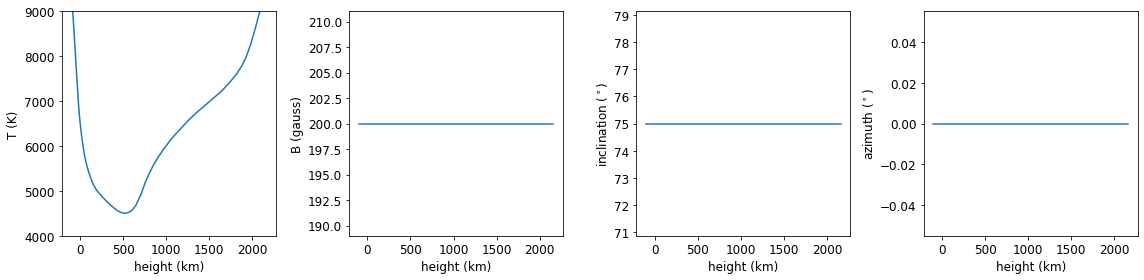

In [10]:
# Read output directory and plot the atmosphere
KM_TO_M = 1.0E3

fig, ax = plt.subplots(1,4, figsize = (16, 4))
ax[0].set_ylim(4000, 9000)
ax[0].set_ylabel('T (K)')
ax[1].set_ylabel('B (gauss)')
ax[2].set_ylabel(r'inclination ($^\circ$)')
ax[3].set_ylabel(r'azimuth ($^\circ$)')
for jj in range(4):
    ax[jj].set_xlabel('height (km)')


# Read the input atmospheres from RH's output directory
falc = rhanalyze.rhout(rhoutput) 
height = falc.geometry.height/ KM_TO_M
tau500 = falc.geometry.tau500

# Plot the Temperature and magnetic field vector as a function of height
ax[0].plot(height, falc.atmos.T)
ax[1].plot(height, falc.atmos.B*10**4)
ax[2].plot(height, falc.atmos.gamma_B*180./np.pi)
ax[3].plot(height, falc.atmos.chi_B*180./np.pi)


plt.tight_layout()


print('Model magnetic field at height index 0: ')
B_mod = falc.atmos.B[0]*10**4
gamma_mod = falc.atmos.gamma_B[0]*180/np.pi
chi_mod = falc.atmos.chi_B[0]*180/np.pi
Bt_mod = B_mod * np.sin(falc.atmos.gamma_B[0])
print('   B = ' + str(B_mod) + ' gauss')
print('   Inclination = ' + format(gamma_mod, '4.1f') + ' deg')
print('   Azimuth = ' + format(chi_mod, '4.1f') + ' deg')
print('   Btrans = ' + format(Bt_mod, '4.1f') + ' gauss')

<h2>Plot I,Q,U,V spectra</h2>

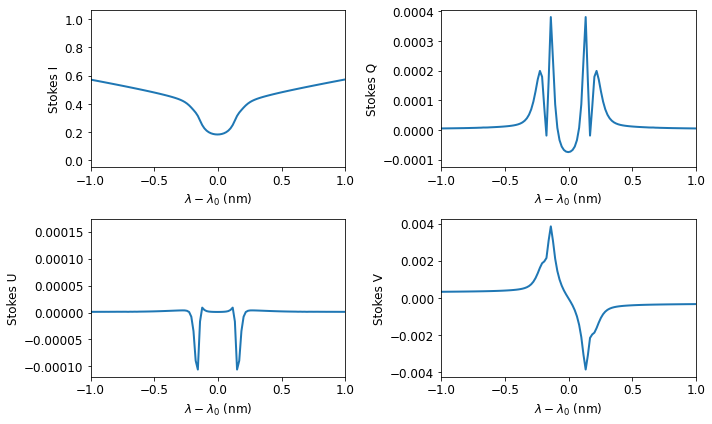

In [6]:
# Read the output directory and plot the Stokes I, Q, U and V spectra

# READ the spectra
falc = rhanalyze.rhout(rhoutput) 
lam = falc.spectrum.waves * 10 
#Find the index of the continuum wavelength
idx_cont = (np.abs(lam - wl_cont)).argmin()

I = falc.rays[0].I
Icont = I[idx_cont]
I = I/Icont

Q = falc.rays[0].Q / Icont
U = falc.rays[0].U / Icont
V = falc.rays[0].V / Icont

### FIGURE: Plot  Stokes I, Q, U and V as a function of wavelength
fig, ax = plt.subplots(2,2, figsize = (10,6))

ax[0,0].plot(lam-lam0, I, linewidth=2.0)
ax[0,1].plot(lam-lam0, Q, linewidth=2.0)
ax[1,0].plot(lam-lam0, U, linewidth=2.0)
ax[1,1].plot(lam-lam0, V, linewidth=2.0) 

ax[0,0].set_ylabel('Stokes I')
ax[0,1].set_ylabel('Stokes Q')
ax[1,0].set_ylabel('Stokes U')
ax[1,1].set_ylabel('Stokes V')
for kk in range(2):
    for jj in range(2):
        ax[jj, kk].set_xlabel(r'$\lambda -\lambda_0$ (nm)')
        ax[jj, kk].set_xlim(-1, 1)
        ax[jj, kk].locator_params(axis="x", nbins=4)
plt.tight_layout()

<h2> Apply the weak field approximation for the horizontal component of the field</h2>

We will first use the equation that relates the linear polarization to the first derivative of Stokes I, which is typically valid in the wings of the line:

$L(\lambda_0) = \frac{3}{4}B_{T}^2 \left|C_{T}\frac{1}{\lambda_w-\lambda_0}\right|\left|\frac{\partial I}{\partial \lambda}\right|$

In [17]:
#  range of wavelengths in the wing
wl1 = 8535.
wl2 = 8540
# range of wavelengths around the core
#wl1 = 8541.8
#wl2 = 8542.05

Bt WFA =  186.4 Gauss, with intercept = 0.000000016
Bt WFA =  187.8 gauss, without intercept
Bt Model =  193.2 gauss


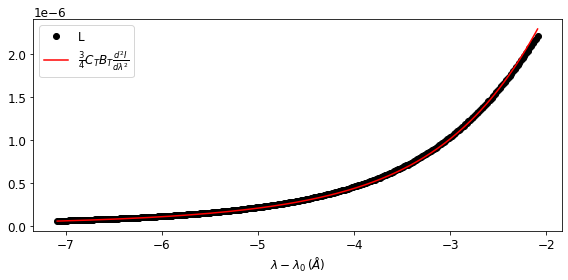

In [18]:
L = np.sqrt(Q**2. + U**2.)   # total linear polarization
dIdlam = np.gradient(I, lam) # derivative of Stokes I

# Cut out wavelength range of interest
indlam = np.argwhere(np.logical_and(lam>=wl1, lam<=wl2)) 
Lline = np.squeeze(L[indlam])
dIdlam_line = np.squeeze(dIdlam[indlam])
lam_line = np.squeeze(lam[indlam])
# Compute the right-hand side of the WFA equation, 
dfactor = 3/4.* Ct * np.abs(1./(lam_line-lam0))*np.abs(dIdlam_line)

# Calculate Bt
# Perform a linear fit of Stokes L to dI/dlam to obtain Bt
# Because the model (WFA) is a linear fit without an intercept,
# We can force the intercept to zero, or alternatively use it as a 
# sanity check for the fit.

# First perform linear fit without intercept
beta = np.sum(Lline * dfactor)/ np.sum(dfactor**2.)
# the slope beta corresponds to Bt**2, so we extract Bt 
Bt = np.sqrt(beta)

# Then repeat linear fit with intercept
from numpy.polynomial import polynomial as P
# perform a linear fit with intercept, for comparison
Bfit = P.polyfit(dfactor,Lline, 1)

print('Bt WFA = ' +format(np.sqrt(Bfit[1]),'6.1f') + ' Gauss, with intercept = '+format(Bfit[0], '6.9f'))  
print('Bt WFA = '+ format(Bt,'6.1f')+ ' gauss, without intercept')
print('Bt Model = '+ format(Bt_mod, '6.1f') + ' gauss')

#### FIGURE: plot L and overplot d2I/dlam2 scaled with C and Blos
fig, ax = plt.subplots(figsize = (8, 4))

ax.plot(lam_line-lam0, Lline, 'ko', label='L')
ax.plot(lam_line-lam0, beta*dfactor, 'r-', label=r'$\frac{3}{4}C_T B_{T} \frac{d^2I}{d\lambda^2}$') 

#ax.set_title('B = '+str(Bvalue)+' G')
ax.set_xlabel(r'$\lambda - \lambda_0\, (\AA) $')
ax.legend()
plt.tight_layout()

<h2> WFA for $\lambda = \lambda_0$</h2>

Let's now use the equation that relates the linear polarization to the second derivative of Stokes I, which is typically valid in the core of the line only:

$L(\lambda_0) = \frac{1}{4}B_{T}^2 \left|C_{T}\frac{\partial^2 I}{\partial \lambda^2}\right|$

In [8]:

L = np.sqrt(Q**2. + U**2.)              # total linear polarization
dIdlam = np.gradient(I, lam)            # first derivative of Stokes I wrt wavelength
d2Idlam2 = np.gradient(dIdlam, lam)     # second derivative of Stokes I

# Find the line center. This should technically be done with a gaussian fit
indlam = np.argmin(np.abs(lam - lam0))
# Calculate the values of the linear polarization and derivative of Stokes I at the line center
Lline = np.squeeze(L[indlam])
d2Idlam2_line = np.squeeze(d2Idlam2[indlam])

# Compute right-hand-side of WFA equation
dfactor = np.abs(d2Idlam2_line*Ct/4.)
# Use WFA  equation and solve for Bt**2
Bt = np.sqrt(Lline/dfactor)


print('Bt WFA = '+ format(Bt,'6.1f')+ ' gauss')
print('Bt Model = '+ format(Bt_mod, '6.1f') + ' gauss')



Bt WFA =  184.1 gauss
Bt Model =  193.2 gauss
